<img src="../img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">

<br><br><br>
<h2><font color="#00586D" size=4>Trabajo Fin de Máster</font></h2>

<h1><font color="#00586D" size=5>Análisis y Predicción de Resultados en Partidas de Clash Royale:<br><b>7. Despliegue</b></font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font><br>
</div>

<font color="#00586D" size=3>Iván Fernández García</font><br>
<font color="#00586D" size=3>Curso académico 2024/2025</font><br>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Predicción de partidas](#section2)
    * [2.1. Creación de nuevos regisitros](#section2_1)
    * [2.2. Integración del modelo](#section2_2)
    * [2.3. Integración de técnicas de explicabilidad](#section2_3)
* [3. Diseño de la aplicación](#section3)
* [4. Conclusiones](#section4)

---

In [220]:
import os
import sys
import requests
import joblib
import shap
import pandas as pd
from datetime import datetime
from sklearn import set_config

In [221]:
set_config(transform_output="pandas")
shap.initjs()

---

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>

Como fase de despliegue, se ha desarrollado una aplicación que integra el modelo y nos permite simular partidas entre dos jugadores cualesquiera. El usuario introduce el tag de ambos jugadores y se cargan sus perfiles a través de la API, mostrando información como el nivel de experiencia o los trofeos actuales. El usuario debe seleccionar las cartas que va a utilizar cada jugador, tanto las ocho del mazo como la tropa de las torres. La colección de cartas de cada jugador puede ser diferente, ya que esta información se obtiene con la API y por lo tanto es posible distinguir niveles, evoluciones, cartas sin desbloquear, etc. Una vez que todas las cartas se han seleccionado, se puede predecir el resultado del enfrentamiento.

---

<a id="section2"></a>
## <font color="#00586D"> 2. Predicción de partidas</font>

La aplicación se ha desarrollado utilizando diferentes herramientas y lenguajes, pero dejando a un lado la parte visual y la lógica para que el usuario interactúe con esta, es fundamental definir la forma de integrar el modelo y predecir una nueva partida con el formato adecuado a partir de la información introducida por el usuario. Además, se han incluido técnicas de explicabilidad para facilitar la interpretación de las predicciones.

<a id="section2_1"></a>
### <font color="#00586D"> 2.1. Creación de nuevos registros</font>

Una vez que el usuario ha introducido los tags de los dos jugadores y ha seleccionado los cartas de cada uno, debemos ser capaces de crear un nuevo registro a partir de esta información, cuyo formato coincida con los ejemplos de nuestro conjunto de datos (antes del preprocesamiento). Este proceso es distinto al que realizamos en fases iniciales para limpiar y transformar la información de las partidas obtenidas a través de la API, ya que ahora partimos de los perfiles y de los identificadores de las cartas seleccionadas.

Vamos a recibir un diccionario para cada jugador, compuesto por tag, identificadores de las cartas del mazo e identificador de la tropa de las torres. Simularemos un nuevo caso con el siguiente ejemplo:

In [222]:
player1 = {
    "tag": "#202GLGUU",
    "deck": [26000064, 26000013, 26000004, 28000000, 27000008, 26000011, 27000006, 27000000],
    "tower": 159000002
}

player2 = {
    "tag": "#88VYQQGC",
    "deck": [26000033, 26000009, 28000006, 26000005, 26000017, 26000062, 27000006, 28000011],
    "tower": 159000000
}

En primer lugar, obtenemos la información de ambos jugadores mediante la API a partir de sus tags:

In [223]:
API_URL = "https://api.clashroyale.com/v1/players/%23{}"
TOKEN = os.getenv("CR_API_TOKEN")
HEADERS = {"Content-type": "application/json", "Authorization": "Bearer " + TOKEN}

def get_all_player_data(tag):
    formatted_tag = tag.replace("#", "")
    url = API_URL.format(formatted_tag)
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": f"Error al obtener datos del jugador {tag}"}

player1_info = get_all_player_data(player1["tag"])
player2_info = get_all_player_data(player2["tag"])

Para obtener las variables propias de la partida de nuestro conjunto de datos, calculamos la fecha actual con el formato adecuado para `battleTime` y nos quedamos con la `arena` del jugador con más trofeos por si esta cambia entre jugadores (porque justo están en el límite o porque estamos ante una partida amistosa entre jugadores de diferentes arenas).

In [224]:
arena_order = [
    "Goblin Stadium", "Bone Pit", "Barbarian Bowl", "Spell Valley", "Builder's Workshop", "P.E.K.K.A's Playhouse", "Royal Arena",
    "Frozen Peak", "Jungle Arena", "Hog Mountain", "Electro Valley", "Spooky Town", "Rascal's Hideout", "Serenity Peak", "Miner's Mine",
    "Executioner's Kitchen", "Royal Crypt", "Silent Sanctuary", "Dragon Spa", "Boot Camp", "Clash Fest", "PANCAKES!", "Legendary Arena"
]

battle_info = pd.DataFrame([{
    "battleTime": pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M:%S")),
    "arena": max(player1_info["arena"]["name"], player2_info["arena"]["name"], key=lambda x: arena_order.index(x))
}])

battle_info

,battleTime,arena
0,2025-05-17 22:39:27,Boot Camp


Creamos, para cada jugador, las variables que no están relacionadas con los mazos:

In [225]:
player1_profile_info = pd.DataFrame([{"player1_tag": player1_info["tag"], "player1_name": player1_info["name"], "player1_startingTrophies": player1_info["trophies"]}])
player2_profile_info = pd.DataFrame([{"player2_tag": player2_info["tag"], "player2_name": player2_info["name"], "player2_startingTrophies": player2_info["trophies"]}])

display(player1_profile_info, player2_profile_info)

,player1_tag,player1_name,player1_startingTrophies
0,#202GLGUU,KILLER,7743


,player2_tag,player2_name,player2_startingTrophies
0,#88VYQQGC,XxByHabboxX,5943


Para crear las variables binarias de los mazos, podemos cargar `df_cards` y asignar el valor 1 a las cartas seleccionadas:

In [226]:
df_cards = pd.read_csv("../data/processed/cards.csv").set_index("id")

player1_binary_deck = pd.DataFrame({f"player1_has{card_name.replace(" ", "")}": [1 if card_id in player1["deck"] else 0] for card_id, card_name in zip(df_cards.index, df_cards["name"])})
player2_binary_deck = pd.DataFrame({f"player2_has{card_name.replace(" ", "")}": [1 if card_id in player2["deck"] else 0] for card_id, card_name in zip(df_cards.index, df_cards["name"])})

display(player1_binary_deck, player2_binary_deck)

,player1_hasKnight,player1_hasArchers,player1_hasGoblins,player1_hasGiant,player1_hasP.E.K.K.A,player1_hasMinions,player1_hasBalloon,player1_hasWitch,player1_hasBarbarians,player1_hasGolem,...,player1_hasTheLog,player1_hasTornado,player1_hasClone,player1_hasEarthquake,player1_hasBarbarianBarrel,player1_hasHealSpirit,player1_hasGiantSnowball,player1_hasRoyalDelivery,player1_hasVoid,player1_hasGoblinCurse
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,player2_hasKnight,player2_hasArchers,player2_hasGoblins,player2_hasGiant,player2_hasP.E.K.K.A,player2_hasMinions,player2_hasBalloon,player2_hasWitch,player2_hasBarbarians,player2_hasGolem,...,player2_hasTheLog,player2_hasTornado,player2_hasClone,player2_hasEarthquake,player2_hasBarbarianBarrel,player2_hasHealSpirit,player2_hasGiantSnowball,player2_hasRoyalDelivery,player2_hasVoid,player2_hasGoblinCurse
0,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


Las variables numéricas que describen los mazos de ambos jugadores requieren más trabajo. Vamos a comenzar filtrando las cartas seleccionadas y fusionando con el resto de propiedades en `df_cards`:

In [228]:
rarity_level_bonus = {"common": 0, "rare": 2, "epic": 5, "legendary": 8, "champion": 10}

player1_cards = pd.DataFrame(player1_info["cards"])

if "evolutionLevel" not in player1_cards.columns:
    player1_cards["evolutionLevel"] = pd.NA

if "starLevel" not in player1_cards.columns:
    player1_cards["starLevel"] = pd.NA

player1_deck_info = (
    player1_cards.set_index("id").loc[player1["deck"]][["name", "level", "starLevel", "evolutionLevel", "rarity", "elixirCost"]]
    .assign(
        isEvolution=lambda df: df["evolutionLevel"].notna(),
        level=lambda df: df["level"] + df["rarity"].map(rarity_level_bonus)
    ).drop(columns=["evolutionLevel"])
    .merge(df_cards[["name", "type", "winCondition", "melee", "ranged", "air", "antiAir", "directDamage", "splashDamage", "resetAttack"]], left_on="name", right_on="name", how="left")
    .add_prefix("player1_card_")
)

player2_cards = pd.DataFrame(player2_info["cards"])

if "evolutionLevel" not in player2_cards.columns:
    player2_cards["evolutionLevel"] = pd.NA

if "starLevel" not in player2_cards.columns:
    player2_cards["starLevel"] = pd.NA

player2_deck_info = (
    player2_cards.set_index("id").loc[player2["deck"]][["name", "level", "starLevel", "evolutionLevel", "rarity", "elixirCost"]]
    .assign(
        isEvolution=lambda df: df["evolutionLevel"].notna(),
        level=lambda df: df["level"] + df["rarity"].map(rarity_level_bonus)
    ).drop(columns=["evolutionLevel"])
    .merge(df_cards[["name", "type", "winCondition", "melee", "ranged", "air", "antiAir", "directDamage", "splashDamage", "resetAttack"]], left_on="name", right_on="name", how="left")
    .add_prefix("player2_card_")
)

decks_info = pd.concat([player1_deck_info, player2_deck_info], axis=1)
decks_info = pd.concat([decks_info.iloc[i].rename(lambda col: col.replace("card", f"card{i+1}")) for i in range(len(decks_info))],axis=0).to_frame().T.reset_index(drop=True)
decks_info

,player1_card1_name,player1_card1_level,player1_card1_starLevel,player1_card1_rarity,player1_card1_elixirCost,player1_card1_isEvolution,player1_card1_type,player1_card1_winCondition,player1_card1_melee,player1_card1_ranged,...,player2_card8_isEvolution,player2_card8_type,player2_card8_winCondition,player2_card8_melee,player2_card8_ranged,player2_card8_air,player2_card8_antiAir,player2_card8_directDamage,player2_card8_splashDamage,player2_card8_resetAttack
0,Firecracker,12,NaN,common,3.0,False,troop,False,False,True,...,False,spell,False,False,False,False,False,True,True,False


Ahora agregamos para obtener los descriptores en lugar de las propiedades de cada una de las cartas.

In [229]:
decks_info = (
    decks_info.assign(
        player1_meanCardLevel=lambda df: df[[f"player1_card{i}_level" for i in range(1, 9)]].mean(axis=1),
        player2_meanCardLevel=lambda df: df[[f"player2_card{i}_level" for i in range(1, 9)]].mean(axis=1),
        player1_minCardLevel=lambda df: df[[f"player1_card{i}_level" for i in range(1, 9)]].min(axis=1),
        player2_minCardLevel=lambda df: df[[f"player2_card{i}_level" for i in range(1, 9)]].min(axis=1),
        player1_maxCardLevel=lambda df: df[[f"player1_card{i}_level" for i in range(1, 9)]].max(axis=1),
        player2_maxCardLevel=lambda df: df[[f"player2_card{i}_level" for i in range(1, 9)]].max(axis=1),
        player1_totalStarLevel=lambda df: df[[f"player1_card{i}_starLevel" for i in range(1, 9)]].sum(axis=1),
        player2_totalStarLevel=lambda df: df[[f"player2_card{i}_starLevel" for i in range(1, 9)]].sum(axis=1),
        player1_meanElixirCost=lambda df: df[[f"player1_card{i}_elixirCost" for i in range(1, 9)]].mean(axis=1),
        player2_meanElixirCost=lambda df: df[[f"player2_card{i}_elixirCost" for i in range(1, 9)]].mean(axis=1),
        player1_numEvolutionCards=lambda df: df[[f"player1_card{i}_isEvolution" for i in range(1, 9)]].sum(axis=1),
        player2_numEvolutionCards=lambda df: df[[f"player2_card{i}_isEvolution" for i in range(1, 9)]].sum(axis=1),
        player1_numWinConditionCards=lambda df: df[[f"player1_card{i}_winCondition" for i in range(1, 9)]].sum(axis=1),
        player2_numWinConditionCards=lambda df: df[[f"player2_card{i}_winCondition" for i in range(1, 9)]].sum(axis=1),
        player1_numMeleeCards=lambda df: df[[f"player1_card{i}_melee" for i in range(1, 9)]].sum(axis=1),
        player2_numMeleeCards=lambda df: df[[f"player2_card{i}_melee" for i in range(1, 9)]].sum(axis=1),
        player1_numRangedCards=lambda df: df[[f"player1_card{i}_ranged" for i in range(1, 9)]].sum(axis=1),
        player2_numRangedCards=lambda df: df[[f"player2_card{i}_ranged" for i in range(1, 9)]].sum(axis=1),
        player1_numAirCards=lambda df: df[[f"player1_card{i}_air" for i in range(1, 9)]].sum(axis=1),
        player2_numAirCards=lambda df: df[[f"player2_card{i}_air" for i in range(1, 9)]].sum(axis=1),
        player1_numAntiAirCards=lambda df: df[[f"player1_card{i}_antiAir" for i in range(1, 9)]].sum(axis=1),
        player2_numAntiAirCards=lambda df: df[[f"player2_card{i}_antiAir" for i in range(1, 9)]].sum(axis=1),
        player1_numDirectDamageCards=lambda df: df[[f"player1_card{i}_directDamage" for i in range(1, 9)]].sum(axis=1),
        player2_numDirectDamageCards=lambda df: df[[f"player2_card{i}_directDamage" for i in range(1, 9)]].sum(axis=1),
        player1_numSplashDamageCards=lambda df: df[[f"player1_card{i}_splashDamage" for i in range(1, 9)]].sum(axis=1),
        player2_numSplashDamageCards=lambda df: df[[f"player2_card{i}_splashDamage" for i in range(1, 9)]].sum(axis=1),
        player1_numResetAttackCards=lambda df: df[[f"player1_card{i}_resetAttack" for i in range(1, 9)]].sum(axis=1),
        player2_numResetAttackCards=lambda df: df[[f"player2_card{i}_resetAttack" for i in range(1, 9)]].sum(axis=1),
        player1_numCommonCards=lambda df: df[[f"player1_card{i}_rarity" for i in range(1, 9)]].eq("common").sum(axis=1),
        player2_numCommonCards=lambda df: df[[f"player2_card{i}_rarity" for i in range(1, 9)]].eq("common").sum(axis=1),
        player1_numRareCards=lambda df: df[[f"player1_card{i}_rarity" for i in range(1, 9)]].eq("rare").sum(axis=1),
        player2_numRareCards=lambda df: df[[f"player2_card{i}_rarity" for i in range(1, 9)]].eq("rare").sum(axis=1),
        player1_numEpicCards=lambda df: df[[f"player1_card{i}_rarity" for i in range(1, 9)]].eq("epic").sum(axis=1),
        player2_numEpicCards=lambda df: df[[f"player2_card{i}_rarity" for i in range(1, 9)]].eq("epic").sum(axis=1),
        player1_numLegendaryCards=lambda df: df[[f"player1_card{i}_rarity" for i in range(1, 9)]].eq("legendary").sum(axis=1),
        player2_numLegendaryCards=lambda df: df[[f"player2_card{i}_rarity" for i in range(1, 9)]].eq("legendary").sum(axis=1),
        player1_numChampionCards=lambda df: df[[f"player1_card{i}_rarity" for i in range(1, 9)]].eq("champion").sum(axis=1),
        player2_numChampionCards=lambda df: df[[f"player2_card{i}_rarity" for i in range(1, 9)]].eq("champion").sum(axis=1),
        player1_numTroopCards=lambda df: df[[f"player1_card{i}_type" for i in range(1, 9)]].eq("troop").sum(axis=1),
        player2_numTroopCards=lambda df: df[[f"player2_card{i}_type" for i in range(1, 9)]].eq("troop").sum(axis=1),
        player1_numBuildingCards=lambda df: df[[f"player1_card{i}_type" for i in range(1, 9)]].eq("building").sum(axis=1),
        player2_numBuildingCards=lambda df: df[[f"player2_card{i}_type" for i in range(1, 9)]].eq("building").sum(axis=1),
        player1_numSpellCards=lambda df: df[[f"player1_card{i}_type" for i in range(1, 9)]].eq("spell").sum(axis=1),
        player2_numSpellCards=lambda df: df[[f"player2_card{i}_type" for i in range(1, 9)]].eq("spell").sum(axis=1)
    ).drop(columns=[
        f"player1_card{i}_level" for i in range(1, 9)] + [f"player2_card{i}_level" for i in range(1, 9)] +
        [f"player1_card{i}_starLevel" for i in range(1, 9)] + [f"player2_card{i}_starLevel" for i in range(1, 9)] +
        [f"player1_card{i}_elixirCost" for i in range(1, 9)] + [f"player2_card{i}_elixirCost" for i in range(1, 9)] +
        [f"player1_card{i}_rarity" for i in range(1, 9)] + [f"player2_card{i}_rarity" for i in range(1, 9)] +
        [f"player1_card{i}_isEvolution" for i in range(1, 9)] + [f"player2_card{i}_isEvolution" for i in range(1, 9)] +
        [f"player1_card{i}_type" for i in range(1, 9)] + [f"player2_card{i}_type" for i in range(1, 9)] +
        [f"player1_card{i}_winCondition" for i in range(1, 9)] + [f"player2_card{i}_winCondition" for i in range(1, 9)] +
        [f"player1_card{i}_melee" for i in range(1, 9)] + [f"player2_card{i}_melee" for i in range(1, 9)] +
        [f"player1_card{i}_ranged" for i in range(1, 9)] + [f"player2_card{i}_ranged" for i in range(1, 9)] +
        [f"player1_card{i}_air" for i in range(1, 9)] + [f"player2_card{i}_air" for i in range(1, 9)] +
        [f"player1_card{i}_antiAir" for i in range(1, 9)] + [f"player2_card{i}_antiAir" for i in range(1, 9)] +
        [f"player1_card{i}_directDamage" for i in range(1, 9)] + [f"player2_card{i}_directDamage" for i in range(1, 9)] +
        [f"player1_card{i}_splashDamage" for i in range(1, 9)] + [f"player2_card{i}_splashDamage" for i in range(1, 9)] +
        [f"player1_card{i}_resetAttack" for i in range(1, 9)] + [f"player2_card{i}_resetAttack" for i in range(1, 9)]
    )
)

decks_info

,player1_card1_name,player2_card1_name,player1_card2_name,player2_card2_name,player1_card3_name,player2_card3_name,player1_card4_name,player2_card4_name,player1_card5_name,player2_card5_name,...,player1_numLegendaryCards,player2_numLegendaryCards,player1_numChampionCards,player2_numChampionCards,player1_numTroopCards,player2_numTroopCards,player1_numBuildingCards,player2_numBuildingCards,player1_numSpellCards,player2_numSpellCards
0,Firecracker,Sparky,Bomber,Golem,P.E.K.K.A,Mirror,Fireball,Minions,X-Bow,Wizard,...,0,3,0,0,4,5,3,1,1,2


Para construir las características relacionadas con los *counters*, lo hacemos de la siguiente manera:

In [230]:
def count_counters(row, df_counters, player_prefix, opponent_prefix):
    counter_count = 0
    for i in range(1, 9):
        card_name = row[f"{player_prefix}_card{i}_name"]
        if card_name in df_counters.index:
            counters = df_counters.loc[card_name, "counters"]
            opponent_cards = [row[f"{opponent_prefix}_card{j}_name"] for j in range(1, 9)]
            counter_count += sum(1 for card in opponent_cards if card in counters)
    return counter_count

def count_uncountered_cards(row, df_counters, player_prefix, opponent_prefix):
    uncountered_count = 0
    for i in range(1, 9):
        card_name = row[f"{player_prefix}_card{i}_name"]
        if card_name in df_counters.index:
            counters = df_counters.loc[card_name, "counters"]
            opponent_cards = [row[f"{opponent_prefix}_card{j}_name"] for j in range(1, 9)]
            if not any(card in counters for card in opponent_cards):
                uncountered_count += 1
        else:
            uncountered_count += 1
    return uncountered_count

df_counters = df_cards.set_index("name")[["counters"]].dropna()
decks_info["player1_numCounters"] = decks_info.apply(lambda row: count_counters(row, df_counters, "player1", "player2"), axis=1)
decks_info["player2_numCounters"] = decks_info.apply(lambda row: count_counters(row, df_counters, "player2", "player1"), axis=1)
decks_info["player1_numUncounteredCards"] = decks_info.apply(lambda row: count_uncountered_cards(row, df_counters, "player1", "player2"), axis=1)
decks_info["player2_numUncounteredCards"] = decks_info.apply(lambda row: count_uncountered_cards(row, df_counters, "player2", "player1"), axis=1)

decks_info = decks_info.drop(columns=[col for col in decks_info.columns if col.endswith("_name")])
player1_deck_info = decks_info.filter(like="player1_")
player2_deck_info = decks_info.filter(like="player2_")

display(player1_deck_info, player2_deck_info)

,player1_meanCardLevel,player1_minCardLevel,player1_maxCardLevel,player1_totalStarLevel,player1_meanElixirCost,player1_numEvolutionCards,player1_numWinConditionCards,player1_numMeleeCards,player1_numRangedCards,player1_numAirCards,...,player1_numCommonCards,player1_numRareCards,player1_numEpicCards,player1_numLegendaryCards,player1_numChampionCards,player1_numTroopCards,player1_numBuildingCards,player1_numSpellCards,player1_numCounters,player1_numUncounteredCards
0,11.75,9,14,2.0,4.125,True,True,True,True,False,...,4,2,2,0,0,4,3,1,5,4


,player2_meanCardLevel,player2_minCardLevel,player2_maxCardLevel,player2_totalStarLevel,player2_meanElixirCost,player2_numEvolutionCards,player2_numWinConditionCards,player2_numMeleeCards,player2_numRangedCards,player2_numAirCards,...,player2_numCommonCards,player2_numRareCards,player2_numEpicCards,player2_numLegendaryCards,player2_numChampionCards,player2_numTroopCards,player2_numBuildingCards,player2_numSpellCards,player2_numCounters,player2_numUncounteredCards
0,10.0,9,12,0,4.571429,False,True,True,True,True,...,2,1,2,3,0,5,1,2,10,2


Por último, creamos las variables de la tropa de las torres para ambos jugadores:

In [231]:
player1_tower_info = (
    pd.DataFrame(player1_info["supportCards"]).set_index("id").loc[player1["tower"]].to_frame().T
    .assign(player1_supportCardLevel=lambda df: df["level"] + df["rarity"].map(rarity_level_bonus))
    .rename(columns={"name": "player1_supportCardName", "rarity": "player1_supportCardRarity"})
    [["player1_supportCardName", "player1_supportCardLevel", "player1_supportCardRarity"]].reset_index(drop=True)
)

player2_tower_info = (
    pd.DataFrame(player2_info["supportCards"]).set_index("id").loc[player2["tower"]].to_frame().T
    .assign(player2_supportCardLevel=lambda df: df["level"] + df["rarity"].map(rarity_level_bonus))
    .rename(columns={"name": "player2_supportCardName", "rarity": "player2_supportCardRarity"})
    [["player2_supportCardName", "player2_supportCardLevel", "player2_supportCardRarity"]].reset_index(drop=True)
)

display(player1_tower_info, player2_tower_info)

,player1_supportCardName,player1_supportCardLevel,player1_supportCardRarity
0,Dagger Duchess,10,legendary


,player2_supportCardName,player2_supportCardLevel,player2_supportCardRarity
0,Tower Princess,12,common


Concatenamos horizontalmente en el orden adecuado para obtener un registro con el formato adecuado:

In [232]:
x = pd.concat([battle_info, player1_profile_info, player1_binary_deck, player1_deck_info, player1_tower_info, player2_profile_info, player2_binary_deck, player2_deck_info, player2_tower_info], axis=1)
x

,battleTime,arena,player1_tag,player1_name,player1_startingTrophies,player1_hasKnight,player1_hasArchers,player1_hasGoblins,player1_hasGiant,player1_hasP.E.K.K.A,...,player2_numLegendaryCards,player2_numChampionCards,player2_numTroopCards,player2_numBuildingCards,player2_numSpellCards,player2_numCounters,player2_numUncounteredCards,player2_supportCardName,player2_supportCardLevel,player2_supportCardRarity
0,2025-05-17 22:39:27,Boot Camp,#202GLGUU,KILLER,7743,0,0,0,0,1,...,3,0,5,1,2,10,2,Tower Princess,12,common


<a id="section2_2"></a>
### <font color="#00586D"> 2.2. Integración del modelo</font>

Para predecir un nuevo registro con el modelo, lo único que tenemos que hacer es cargarlo junto a las funciones de preprocesamiento y utilizar el método `predict` o `predict_proba` según el uso que le queramos dar:

In [233]:
sys.path.append(os.path.abspath('..'))

from preprocessing_functions import (
    create_diff_starting_trophies, create_diff_mean_card_level, create_diff_min_card_level, create_diff_max_card_level,
    create_diff_support_card_level, create_diff_total_star_level, create_diff_mean_elixir_cost, create_diff_num_evolution_cards,
    create_diff_num_win_condition_cards, create_diff_num_melee_cards, create_diff_num_ranged_cards, create_diff_num_air_cards,
    create_diff_num_anti_air_cards, create_diff_num_direct_damage_cards, create_diff_num_splash_damage_cards, create_diff_num_reset_attack_cards,
    create_diff_num_common_cards, create_diff_num_rare_cards, create_diff_num_epic_cards, create_diff_num_legendary_cards, create_diff_num_champion_cards,
    create_diff_num_troop_cards, create_diff_num_building_cards, create_diff_num_spell_cards, create_diff_num_counters,
    create_diff_num_uncountered_cards, create_win_condition_advantage, create_rarity_score, create_balance_score
)

model = joblib.load("../pipelines/models/model.joblib")

pred = model.predict(x)[0]
player1_win_prob, player2_win_prob = model.predict_proba(x).flatten()

print(f"Predicción: {pred}")
print(f"Probabilidad de victoria del primer jugador: {player1_win_prob * 100:.2f}%")
print(f"Probabilidad de victoria del segundo jugador: {player2_win_prob * 100:.2f}%")

Predicción: player1
Probabilidad de victoria del primer jugador: 71.24%
Probabilidad de victoria del segundo jugador: 28.76%


Para aplicar las técnicas de explicabilidad necesitamos considerar las variables con las que aprendió el modelo, que coinciden con la salida del preprocesamiento (incluyendo las diferencias creadas). Vamos a verificar que llamar a `transform` con el *pipeline* de preprocesamiento y predecir el registro transformado directamente con el estimador es equivalente:

In [234]:
preprocessing = model.named_steps["preprocessing"]
estimator = model.named_steps["estimator"]

x_transformed = preprocessing.transform(x)
x_transformed

,diff_meanCardLevel,diff_minCardLevel,diff_maxCardLevel,diff_supportCardLevel,diff_totalStarLevel,diff_meanElixirCost,diff_numEvolutionCards,diff_numWinConditionCards,diff_numMeleeCards,diff_numRangedCards,...,player2_hasTheLog,player2_hasTornado,player2_hasClone,player2_hasEarthquake,player2_hasBarbarianBarrel,player2_hasHealSpirit,player2_hasGiantSnowball,player2_hasRoyalDelivery,player2_hasVoid,player2_hasGoblinCurse
0,2.198734,0.043748,1.863553,-2.200683,0.154107,-0.717944,0.849769,0.005009,-0.061658,-0.075964,...,1,0,0,0,0,0,0,0,0,0


In [235]:
pred = estimator.predict(x_transformed)[0]
player1_win_prob, player2_win_prob = estimator.predict_proba(x_transformed).flatten()

print(f"Predicción: {pred}")
print(f"Probabilidad de victoria del primer jugador: {player1_win_prob * 100:.2f}%")
print(f"Probabilidad de victoria del segundo jugador: {player2_win_prob * 100:.2f}%")

Predicción: player1
Probabilidad de victoria del primer jugador: 71.24%
Probabilidad de victoria del segundo jugador: 28.76%


Esto ocurre porque el *pipeline* llama automáticamente a `transform` cuando predecimos y la salida del preprocesamiento es justamente esta entrada transformada que utiliza el clasificador que tiene como último paso.

<a id="section2_3"></a>
### <font color="#00586D"> 2.3. Integración de técnicas de explicabilidad</font>

A partir del estimador y el nuevo registro transformado, podemos calcular los valores SHAP:

In [236]:
explainer = shap.Explainer(estimator)

instance_impact = (
    pd.DataFrame({"feature": x_transformed.columns, "impact": explainer(x_transformed).values.flatten()})
    .sort_values("impact", key=abs, ascending=False)
    .reset_index(drop=True)
)

instance_impact.head(10)

,feature,impact
0,diff_meanCardLevel,-0.753826
1,player2_totalStarLevel,-0.360020
2,player1_numBuildingCards,0.280599
3,diff_supportCardLevel,0.198285
4,diff_maxCardLevel,-0.195210
5,player1_hasCannon,0.086607
6,player2_hasSparky,0.080038
7,diff_numCounters,-0.079698
8,player1_supportCardName_Tower Princess,0.078658
9,player2_hasMirror,-0.063964


Las fuerzas se pueden apreciar mejor en los gráficos. Los valores negativos coresponden a las variables que favorecen la victoria del primer jugador, mientras que los positivos a las variables que favorecen la victoria del segundo jugador.

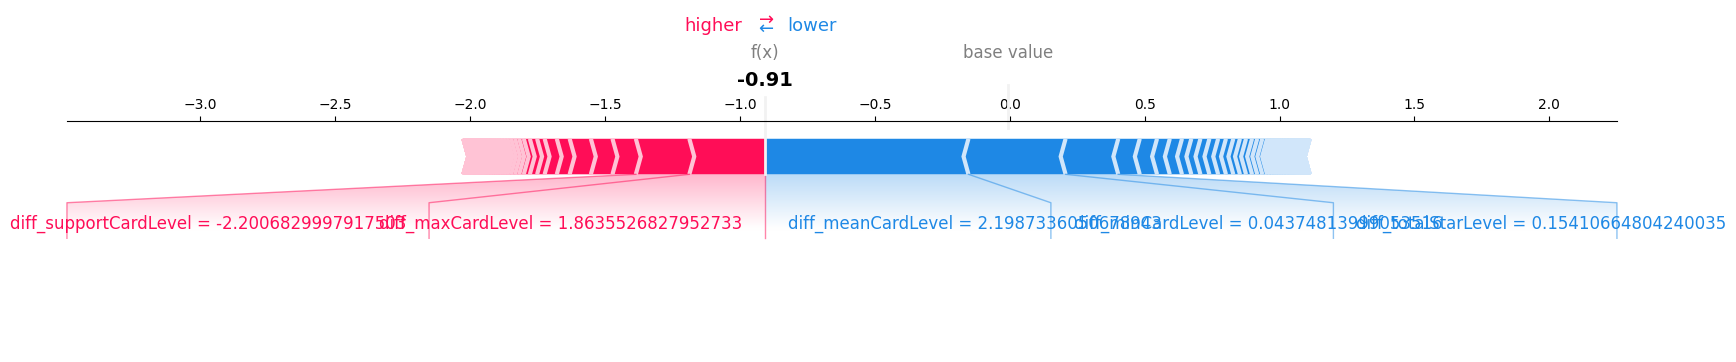

In [237]:
shap.force_plot(explainer.expected_value, instance_impact["impact"].values, x_transformed, matplotlib=True)

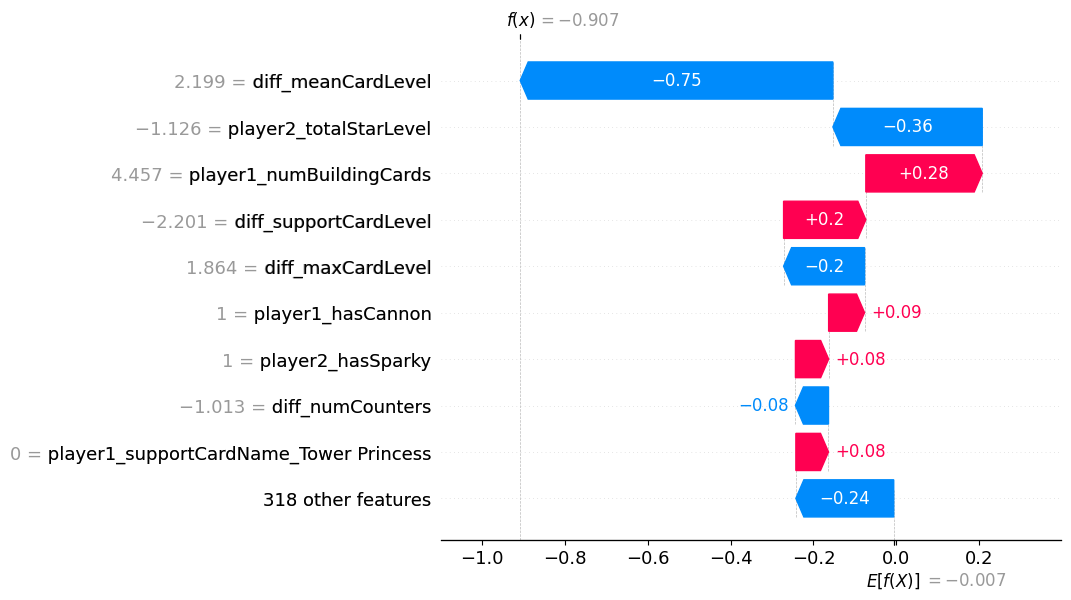

In [238]:
shap.plots.waterfall(explainer(x_transformed)[0])

Para que el usuario comprenda mejor qué factores influyen en la predicción, podemos definir una explicación que represente el significado de cada variable:

In [239]:
translations = {
    'diff_meanCardLevel': 'Diferencia en el nivel medio de las cartas',
    'diff_minCardLevel': 'Diferencia en el nivel mínimo de las cartas',
    'diff_maxCardLevel': 'Diferencia en el nivel máximo de las cartas',
    'diff_supportCardLevel': 'Diferencia en el nivel de la carta de soporte',
    'diff_totalStarLevel': 'Diferencia en el nivel estelar total',
    'diff_meanElixirCost': 'Diferencia en el coste medio de elixir',
    'diff_numEvolutionCards': 'Diferencia en el número de cartas con evolución',
    'diff_numWinConditionCards': 'Diferencia en el número de cartas "Win Condition"',
    'diff_numMeleeCards': 'Diferencia en el número de cartas cuerpo a cuerpo',
    'diff_numRangedCards': 'Diferencia en el número de cartas a distancia',
    'diff_numAirCards': 'Diferencia en el número de cartas aéreas',
    'diff_numAntiAirCards': 'Diferencia en el número de cartas antiaéreas',
    'diff_numDirectDamageCards': 'Diferencia en el número de cartas de daño directo',
    'diff_numSplashDamageCards': 'Diferencia en el número de cartas de daño en área',
    'diff_numResetAttackCards': 'Diferencia en el número de cartas que reinician ataques',
    'diff_numCommonCards': 'Diferencia en el número de cartas comunes',
    'diff_numRareCards': 'Diferencia en el número de cartas raras',
    'diff_numEpicCards': 'Diferencia en el número de cartas épicas',
    'diff_numLegendaryCards': 'Diferencia en el número de cartas legendarias',
    'diff_numChampionCards': 'Diferencia en el número de campeones',
    'diff_numTroopCards': 'Diferencia en el número de tropas',
    'diff_numBuildingCards': 'Diferencia en el número de edificios',
    'diff_numCounters': 'Diferencia en el número de "counters"',
    'diff_numUncounteredCards': 'Diferencia en el número de cartas sin "counters"',
    'diff_winConditionAdvantage': 'Diferencia en la ventaja de "Win Condition" sobre el número de edificios',
    'diff_rarityScore': 'Diferencia en la puntuación de rareza del mazo',
    'diff_balanceScore': 'Diferencia en la puntuación de equilibrio del mazo',
    'player1_meanCardLevel': 'Nivel medio de las cartas del primer jugador',
    'player2_meanCardLevel': 'Nivel medio de las cartas del segundo jugador',
    'player1_minCardLevel': 'Nivel mínimo de las cartas del primer jugador',
    'player2_minCardLevel': 'Nivel mínimo de las cartas del segundo jugador',
    'player1_maxCardLevel': 'Nivel máximo de las cartas del primer jugador',
    'player2_maxCardLevel': 'Nivel máximo de las cartas del segundo jugador',
    'player1_supportCardLevel': 'Nivel de la carta de soporte del primer jugador',
    'player2_supportCardLevel': 'Nivel de la carta de soporte del segundo jugador',
    'player1_totalStarLevel': 'Nivel estelar total del primer jugador',
    'player2_totalStarLevel': 'Nivel estelar total del segundo jugador',
    'player1_meanElixirCost': 'Coste medio de elixir del primer jugador',
    'player2_meanElixirCost': 'Coste medio de elixir del segundo jugador',
    'player1_numEvolutionCards': 'Número de cartas con evolución del primer jugador',
    'player2_numEvolutionCards': 'Número de cartas con evolución del segundo jugador',
    'player1_numWinConditionCards': 'Número de cartas "Win Condition" del primer jugador',
    'player2_numWinConditionCards': 'Número de cartas "Win Condition" del segundo jugador',
    'player1_numMeleeCards': 'Número de cartas cuerpo a cuerpo del primer jugador',
    'player2_numMeleeCards': 'Número de cartas cuerpo a cuerpo del segundo jugador',
    'player1_numRangedCards': 'Número de cartas a distancia del primer jugador',
    'player2_numRangedCards': 'Número de cartas a distancia del segundo jugador',
    'player1_numAirCards': 'Número de cartas aéreas del primer jugador',
    'player2_numAirCards': 'Número de cartas aéreas del segundo jugador',
    'player1_numAntiAirCards': 'Número de cartas antiaéreas del primer jugador',
    'player2_numAntiAirCards': 'Número de cartas antiaéreas del segundo jugador',
    'player1_numDirectDamageCards': 'Número de cartas de daño directo del primer jugador',
    'player2_numDirectDamageCards': 'Número de cartas de daño directo del segundo jugador',
    'player1_numSplashDamageCards': 'Número de cartas de daño en área del primer jugador',
    'player2_numSplashDamageCards': 'Número de cartas de daño en área del segundo jugador',
    'player1_numResetAttackCards': 'Número de cartas que reinician ataques del primer jugador',
    'player2_numResetAttackCards': 'Número de cartas que reinician ataques del segundo jugador',
    'player1_numCommonCards': 'Número de cartas comunes del primer jugador',
    'player2_numCommonCards': 'Número de cartas comunes del segundo jugador',
    'player1_numRareCards': 'Número de cartas raras del primer jugador',
    'player2_numRareCards': 'Número de cartas raras del segundo jugador',
    'player1_numEpicCards': 'Número de cartas épicas del primer jugador',
    'player2_numEpicCards': 'Número de cartas épicas del segundo jugador',
    'player1_numLegendaryCards': 'Número de cartas legendarias del primer jugador',
    'player2_numLegendaryCards': 'Número de cartas legendarias del segundo jugador',
    'player1_numChampionCards': 'Número de campeones del primer jugador',
    'player2_numChampionCards': 'Número de campeones del segundo jugador',
    'player1_numTroopCards': 'Número de tropas del primer jugador',
    'player2_numTroopCards': 'Número de tropas del segundo jugador',
    'player1_numBuildingCards': 'Número de edificios del primer jugador',
    'player2_numBuildingCards': 'Número de edificios del segundo jugador',
    'player1_numCounters': 'Número de "counters" del primer jugador',
    'player2_numCounters': 'Número de "counters" del segundo jugador',
    'player1_numUncounteredCards': 'Número de cartas sin "counters" del primer jugador',
    'player2_numUncounteredCards': 'Número de cartas sin "counters" del segundo jugador',
    'player1_winConditionAdvantage': 'Ventaja de "Win Condition" sobre el número de edificios del primer jugador',
    'player2_winConditionAdvantage': 'Ventaja de "Win Condition" sobre el número de edificios del segundo jugador',
    'player1_rarityScore': 'Puntuación de rareza del mazo del primer jugador',
    'player2_rarityScore': 'Puntuación de rareza del mazo del segundo jugador',
    'player1_balanceScore': 'Puntuación de equilibrio del mazo del primer jugador',
    'player2_balanceScore': 'Puntuación de equilibrio del mazo del segundo jugador',
    'player1_supportCardName_Cannoneer': 'El primer jugador juega o no Cañonero',
    'player1_supportCardName_Dagger Duchess': 'El primer jugador juega o no Duquesa de dagas',
    'player1_supportCardName_Royal Chef': 'El primer jugador juega o no Cocinero real',
    'player1_supportCardName_Tower Princess': 'El primer jugador juega o no Princesa de torre',
    'player2_supportCardName_Cannoneer': 'El segundo jugador juega o no Cañonero',
    'player2_supportCardName_Dagger Duchess': 'El segundo jugador juega o no Duquesa de dagas',
    'player2_supportCardName_Royal Chef': 'El segundo jugador juega o no Cocinero real',
    'player2_supportCardName_Tower Princess': 'El segundo jugador juega o no Princesa de torre',
    'player1_hasKnight': 'El primer jugador juega o no Caballero',
    'player1_hasArchers': 'El primer jugador juega o no Arqueras',
    'player1_hasGoblins': 'El primer jugador juega o no Duendes',
    'player1_hasGiant': 'El primer jugador juega o no Gigante',
    'player1_hasP.E.K.K.A': 'El primer jugador juega o no P.E.K.K.A',
    'player1_hasMinions': 'El primer jugador juega o no Esbirros',
    'player1_hasBalloon': 'El primer jugador juega o no Globo',
    'player1_hasWitch': 'El primer jugador juega o no Bruja',
    'player1_hasBarbarians': 'El primer jugador juega o no Bárbaros',
    'player1_hasGolem': 'El primer jugador juega o no Gólem',
    'player1_hasSkeletons': 'El primer jugador juega o no Esqueletos',
    'player1_hasValkyrie': 'El primer jugador juega o no Valquiria',
    'player1_hasSkeletonArmy': 'El primer jugador juega o no Ejército de esqueletos',
    'player1_hasBomber': 'El primer jugador juega o no Bombardero',
    'player1_hasMusketeer': 'El primer jugador juega o no Mosquetera',
    'player1_hasBabyDragon': 'El primer jugador juega o no Bebé dragón',
    'player1_hasPrince': 'El primer jugador juega o no Príncipe',
    'player1_hasWizard': 'El primer jugador juega o no Mago',
    'player1_hasMiniP.E.K.K.A': 'El primer jugador juega o no Mini P.E.K.K.A',
    'player1_hasSpearGoblins': 'El primer jugador juega o no Duendes con lanza',
    'player1_hasGiantSkeleton': 'El primer jugador juega o no Esqueleto gigante',
    'player1_hasHogRider': 'El primer jugador juega o no Montapuercos',
    'player1_hasMinionHorde': 'El primer jugador juega o no Horda de esbirros',
    'player1_hasIceWizard': 'El primer jugador juega o no Mago de hielo',
    'player1_hasRoyalGiant': 'El primer jugador juega o no Gigante noble',
    'player1_hasGuards': 'El primer jugador juega o no Guardias',
    'player1_hasPrincess': 'El primer jugador juega o no Princesa',
    'player1_hasDarkPrince': 'El primer jugador juega o no Príncipe oscuro',
    'player1_hasThreeMusketeers': 'El primer jugador juega o no Trío de mosqueteras',
    'player1_hasLavaHound': 'El primer jugador juega o no Sabueso de lava',
    'player1_hasIceSpirit': 'El primer jugador juega o no Espíritu de hielo',
    'player1_hasFireSpirit': 'El primer jugador juega o no Espíritu de fuego',
    'player1_hasMiner': 'El primer jugador juega o no Minero',
    'player1_hasSparky': 'El primer jugador juega o no Chispitas',
    'player1_hasBowler': 'El primer jugador juega o no Lanzarrocas',
    'player1_hasLumberjack': 'El primer jugador juega o no Leñador',
    'player1_hasBattleRam': 'El primer jugador juega o no Ariete de batalla',
    'player1_hasInfernoDragon': 'El primer jugador juega o no Dragón infernal',
    'player1_hasIceGolem': 'El primer jugador juega o no Gólem de hielo',
    'player1_hasMegaMinion': 'El primer jugador juega o no Megaesbirro',
    'player1_hasDartGoblin': 'El primer jugador juega o no Duende lanzadardos',
    'player1_hasGoblinGang': 'El primer jugador juega o no Pandilla de duendes',
    'player1_hasElectroWizard': 'El primer jugador juega o no Mago eléctrico',
    'player1_hasEliteBarbarians': 'El primer jugador juega o no Bárbaros de élite',
    'player1_hasHunter': 'El primer jugador juega o no Cazador',
    'player1_hasExecutioner': 'El primer jugador juega o no Verdugo',
    'player1_hasBandit': 'El primer jugador juega o no Bandida',
    'player1_hasRoyalRecruits': 'El primer jugador juega o no Reclutas reales',
    'player1_hasNightWitch': 'El primer jugador juega o no Bruja nocturna',
    'player1_hasBats': 'El primer jugador juega o no Murciélagos',
    'player1_hasRoyalGhost': 'El primer jugador juega o no Fantasma real',
    'player1_hasRamRider': 'El primer jugador juega o no Montacarneros',
    'player1_hasZappies': 'El primer jugador juega o no Chispitas',
    'player1_hasRascals': 'El primer jugador juega o no Pillos',
    'player1_hasCannonCart': 'El primer jugador juega o no Cañón con ruedas',
    'player1_hasMegaKnight': 'El primer jugador juega o no Megacaballero',
    'player1_hasSkeletonBarrel': 'El primer jugador juega o no Barril de esqueletos',
    'player1_hasFlyingMachine': 'El primer jugador juega o no Máquina voladora',
    'player1_hasWallBreakers': 'El primer jugador juega o no Rompemuros',
    'player1_hasRoyalHogs': 'El primer jugador juega o no Puercos reales',
    'player1_hasGoblinGiant': 'El primer jugador juega o no Duende gigante',
    'player1_hasFisherman': 'El primer jugador juega o no Pescador',
    'player1_hasMagicArcher': 'El primer jugador juega o no Arquero mágico',
    'player1_hasElectroDragon': 'El primer jugador juega o no Dragón eléctrico',
    'player1_hasFirecracker': 'El primer jugador juega o no Lanzafuegos',
    'player1_hasMightyMiner': 'El primer jugador juega o no Gran minero',
    'player1_hasElixirGolem': 'El primer jugador juega o no Gólem de elixir',
    'player1_hasBattleHealer': 'El primer jugador juega o no Curandera guerrera',
    'player1_hasSkeletonKing': 'El primer jugador juega o no Rey esqueleto',
    'player1_hasArcherQueen': 'El primer jugador juega o no Reina arquera',
    'player1_hasGoldenKnight': 'El primer jugador juega o no Caballero dorado',
    'player1_hasMonk': 'El primer jugador juega o no Monje',
    'player1_hasSkeletonDragons': 'El primer jugador juega o no Dragones esqueleto',
    'player1_hasMotherWitch': 'El primer jugador juega o no Bruja madre',
    'player1_hasElectroSpirit': 'El primer jugador juega o no Espíritu eléctrico',
    'player1_hasElectroGiant': 'El primer jugador juega o no Gigante eléctrico',
    'player1_hasPhoenix': 'El primer jugador juega o no Fénix',
    'player1_hasLittlePrince': 'El primer jugador juega o no Principito',
    'player1_hasGoblinDemolisher': 'El primer jugador juega o no Demoledor duende',
    'player1_hasGoblinMachine': 'El primer jugador juega o no Máquina duende',
    'player1_hasSuspiciousBush': 'El primer jugador juega o no Arbusto sospechoso',
    'player1_hasGoblinstein': 'El primer jugador juega o no Duendenstein',
    'player1_hasRuneGiant': 'El primer jugador juega o no Gigante rúnica',
    'player1_hasBerserker': 'El primer jugador juega o no Berserker',
    'player1_hasBossBandit': 'El primer jugador juega o no Bandida líder',
    'player1_hasCannon': 'El primer jugador juega o no Cañón',
    'player1_hasGoblinHut': 'El primer jugador juega o no Choza de duendes',
    'player1_hasMortar': 'El primer jugador juega o no Mortero',
    'player1_hasInfernoTower': 'El primer jugador juega o no Torre infernal',
    'player1_hasBombTower': 'El primer jugador juega o no Torre bombardera',
    'player1_hasBarbarianHut': 'El primer jugador juega o no Choza de bárbaros',
    'player1_hasTesla': 'El primer jugador juega o no Tesla',
    'player1_hasElixirCollector': 'El primer jugador juega o no Recolector de elixir',
    'player1_hasX-Bow': 'El primer jugador juega o no Ballesta',
    'player1_hasTombstone': 'El primer jugador juega o no Lápida',
    'player1_hasFurnace': 'El primer jugador juega o no Horno',
    'player1_hasGoblinCage': 'El primer jugador juega o no Jaula del forzudo',
    'player1_hasGoblinDrill': 'El primer jugador juega o no Excavadora de duendes',
    'player1_hasFireball': 'El primer jugador juega o no Bola de fuego',
    'player1_hasArrows': 'El primer jugador juega o no Flechas',
    'player1_hasRage': 'El primer jugador juega o no Furia',
    'player1_hasRocket': 'El primer jugador juega o no Cohete',
    'player1_hasGoblinBarrel': 'El primer jugador juega o no Barril de duendes',
    'player1_hasFreeze': 'El primer jugador juega o no Hielo',
    'player1_hasMirror': 'El primer jugador juega o no Espejo',
    'player1_hasLightning': 'El primer jugador juega o no Rayo',
    'player1_hasZap': 'El primer jugador juega o no Descarga',
    'player1_hasPoison': 'El primer jugador juega o no Veneno',
    'player1_hasGraveyard': 'El primer jugador juega o no Cementerio',
    'player1_hasTheLog': 'El primer jugador juega o no El Tronco',
    'player1_hasTornado': 'El primer jugador juega o no Tornado',
    'player1_hasClone': 'El primer jugador juega o no Clon',
    'player1_hasEarthquake': 'El primer jugador juega o no Terremoto',
    'player1_hasBarbarianBarrel': 'El primer jugador juega o no Barril de bárbaros',
    'player1_hasHealSpirit': 'El primer jugador juega o no Espíritu sanador',
    'player1_hasGiantSnowball': 'El primer jugador juega o no Bola de nieve',
    'player1_hasRoyalDelivery': 'El primer jugador juega o no Paquete real',
    'player1_hasVoid': 'El primer jugador juega o no Vacío',
    'player1_hasGoblinCurse': 'El primer jugador juega o no Maldición duende',
    'player2_hasKnight': 'El segundo jugador juega o no Caballero',
    'player2_hasArchers': 'El segundo jugador juega o no Arqueras',
    'player2_hasGoblins': 'El segundo jugador juega o no Duendes',
    'player2_hasGiant': 'El segundo jugador juega o no Gigante',
    'player2_hasP.E.K.K.A': 'El segundo jugador juega o no P.E.K.K.A',
    'player2_hasMinions': 'El segundo jugador juega o no Esbirros',
    'player2_hasBalloon': 'El segundo jugador juega o no Globo',
    'player2_hasWitch': 'El segundo jugador juega o no Bruja',
    'player2_hasBarbarians': 'El segundo jugador juega o no Bárbaros',
    'player2_hasGolem': 'El segundo jugador juega o no Gólem',
    'player2_hasSkeletons': 'El segundo jugador juega o no Esqueletos',
    'player2_hasValkyrie': 'El segundo jugador juega o no Valquiria',
    'player2_hasSkeletonArmy': 'El segundo jugador juega o no Ejército de esqueletos',
    'player2_hasBomber': 'El segundo jugador juega o no Bombardero',
    'player2_hasMusketeer': 'El segundo jugador juega o no Mosquetera',
    'player2_hasBabyDragon': 'El segundo jugador juega o no Bebé dragón',
    'player2_hasPrince': 'El segundo jugador juega o no Príncipe',
    'player2_hasWizard': 'El segundo jugador juega o no Mago',
    'player2_hasMiniP.E.K.K.A': 'El segundo jugador juega o no Mini P.E.K.K.A',
    'player2_hasSpearGoblins': 'El segundo jugador juega o no Duendes con lanza',
    'player2_hasGiantSkeleton': 'El segundo jugador juega o no Esqueleto gigante',
    'player2_hasHogRider': 'El segundo jugador juega o no Montapuercos',
    'player2_hasMinionHorde': 'El segundo jugador juega o no Horda de esbirros',
    'player2_hasIceWizard': 'El segundo jugador juega o no Mago de hielo',
    'player2_hasRoyalGiant': 'El segundo jugador juega o no Gigante noble',
    'player2_hasGuards': 'El segundo jugador juega o no Guardias',
    'player2_hasPrincess': 'El segundo jugador juega o no Princesa',
    'player2_hasDarkPrince': 'El segundo jugador juega o no Príncipe oscuro',
    'player2_hasThreeMusketeers': 'El segundo jugador juega o no Trío de mosqueteras',
    'player2_hasLavaHound': 'El segundo jugador juega o no Sabueso de lava',
    'player2_hasIceSpirit': 'El segundo jugador juega o no Espíritu de hielo',
    'player2_hasFireSpirit': 'El segundo jugador juega o no Espíritu de fuego',
    'player2_hasMiner': 'El segundo jugador juega o no Minero',
    'player2_hasSparky': 'El segundo jugador juega o no Chispitas',
    'player2_hasBowler': 'El segundo jugador juega o no Lanzarrocas',
    'player2_hasLumberjack': 'El segundo jugador juega o no Leñador',
    'player2_hasBattleRam': 'El segundo jugador juega o no Ariete de batalla',
    'player2_hasInfernoDragon': 'El segundo jugador juega o no Dragón infernal',
    'player2_hasIceGolem': 'El segundo jugador juega o no Gólem de hielo',
    'player2_hasMegaMinion': 'El segundo jugador juega o no Megaesbirro',
    'player2_hasDartGoblin': 'El segundo jugador juega o no Duende lanzadardos',
    'player2_hasGoblinGang': 'El segundo jugador juega o no Pandilla de duendes',
    'player2_hasElectroWizard': 'El segundo jugador juega o no Mago eléctrico',
    'player2_hasEliteBarbarians': 'El segundo jugador juega o no Bárbaros de élite',
    'player2_hasHunter': 'El segundo jugador juega o no Cazador',
    'player2_hasExecutioner': 'El segundo jugador juega o no Verdugo',
    'player2_hasBandit': 'El segundo jugador juega o no Bandida',
    'player2_hasRoyalRecruits': 'El segundo jugador juega o no Reclutas reales',
    'player2_hasNightWitch': 'El segundo jugador juega o no Bruja nocturna',
    'player2_hasBats': 'El segundo jugador juega o no Murciélagos',
    'player2_hasRoyalGhost': 'El segundo jugador juega o no Fantasma real',
    'player2_hasRamRider': 'El segundo jugador juega o no Montacarneros',
    'player2_hasZappies': 'El segundo jugador juega o no Chispitas',
    'player2_hasRascals': 'El segundo jugador juega o no Pillos',
    'player2_hasCannonCart': 'El segundo jugador juega o no Cañón con ruedas',
    'player2_hasMegaKnight': 'El segundo jugador juega o no Megacaballero',
    'player2_hasSkeletonBarrel': 'El segundo jugador juega o no Barril de esqueletos',
    'player2_hasFlyingMachine': 'El segundo jugador juega o no Máquina voladora',
    'player2_hasWallBreakers': 'El segundo jugador juega o no Rompemuros',
    'player2_hasRoyalHogs': 'El segundo jugador juega o no Puercos reales',
    'player2_hasGoblinGiant': 'El segundo jugador juega o no Duende gigante',
    'player2_hasFisherman': 'El segundo jugador juega o no Pescador',
    'player2_hasMagicArcher': 'El segundo jugador juega o no Arquero mágico',
    'player2_hasElectroDragon': 'El segundo jugador juega o no Dragón eléctrico',
    'player2_hasFirecracker': 'El segundo jugador juega o no Lanzafuegos',
    'player2_hasMightyMiner': 'El segundo jugador juega o no Gran minero',
    'player2_hasElixirGolem': 'El segundo jugador juega o no Gólem de elixir',
    'player2_hasBattleHealer': 'El segundo jugador juega o no Curandera guerrera',
    'player2_hasSkeletonKing': 'El segundo jugador juega o no Rey esqueleto',
    'player2_hasArcherQueen': 'El segundo jugador juega o no Reina arquera',
    'player2_hasGoldenKnight': 'El segundo jugador juega o no Caballero dorado',
    'player2_hasMonk': 'El segundo jugador juega o no Monje',
    'player2_hasSkeletonDragons': 'El segundo jugador juega o no Dragones esqueleto',
    'player2_hasMotherWitch': 'El segundo jugador juega o no Bruja madre',
    'player2_hasElectroSpirit': 'El segundo jugador juega o no Espíritu eléctrico',
    'player2_hasElectroGiant': 'El segundo jugador juega o no Gigante eléctrico',
    'player2_hasPhoenix': 'El segundo jugador juega o no Fénix',
    'player2_hasLittlePrince': 'El segundo jugador juega o no Principito',
    'player2_hasGoblinDemolisher': 'El segundo jugador juega o no Demoledor duende',
    'player2_hasGoblinMachine': 'El segundo jugador juega o no Máquina duende',
    'player2_hasSuspiciousBush': 'El segundo jugador juega o no Arbusto sospechoso',
    'player2_hasGoblinstein': 'El segundo jugador juega o no Duendenstein',
    'player2_hasRuneGiant': 'El segundo jugador juega o no Gigante rúnica',
    'player2_hasBerserker': 'El segundo jugador juega o no Berserker',
    'player2_hasBossBandit': 'El segundo jugador juega o no Bandida líder',
    'player2_hasCannon': 'El segundo jugador juega o no Cañón',
    'player2_hasGoblinHut': 'El segundo jugador juega o no Choza de duendes',
    'player2_hasMortar': 'El segundo jugador juega o no Mortero',
    'player2_hasInfernoTower': 'El segundo jugador juega o no Torre infernal',
    'player2_hasBombTower': 'El segundo jugador juega o no Torre bombardera',
    'player2_hasBarbarianHut': 'El segundo jugador juega o no Choza de bárbaros',
    'player2_hasTesla': 'El segundo jugador juega o no Tesla',
    'player2_hasElixirCollector': 'El segundo jugador juega o no Recolector de elixir',
    'player2_hasX-Bow': 'El segundo jugador juega o no Ballesta',
    'player2_hasTombstone': 'El segundo jugador juega o no Lápida',
    'player2_hasFurnace': 'El segundo jugador juega o no Horno',
    'player2_hasGoblinCage': 'El segundo jugador juega o no Jaula del forzudo',
    'player2_hasGoblinDrill': 'El segundo jugador juega o no Excavadora de duendes',
    'player2_hasFireball': 'El segundo jugador juega o no Bola de fuego',
    'player2_hasArrows': 'El segundo jugador juega o no Flechas',
    'player2_hasRage': 'El segundo jugador juega o no Furia',
    'player2_hasRocket': 'El segundo jugador juega o no Cohete',
    'player2_hasGoblinBarrel': 'El segundo jugador juega o no Barril de duendes',
    'player2_hasFreeze': 'El segundo jugador juega o no Hielo',
    'player2_hasMirror': 'El segundo jugador juega o no Espejo',
    'player2_hasLightning': 'El segundo jugador juega o no Rayo',
    'player2_hasZap': 'El segundo jugador juega o no Descarga',
    'player2_hasPoison': 'El segundo jugador juega o no Veneno',
    'player2_hasGraveyard': 'El segundo jugador juega o no Cementerio',
    'player2_hasTheLog': 'El segundo jugador juega o no El Tronco',
    'player2_hasTornado': 'El segundo jugador juega o no Tornado',
    'player2_hasClone': 'El segundo jugador juega o no Clon',
    'player2_hasEarthquake': 'El segundo jugador juega o no Terremoto',
    'player2_hasBarbarianBarrel': 'El segundo jugador juega o no Barril de bárbaros',
    'player2_hasHealSpirit': 'El segundo jugador juega o no Espíritu sanador',
    'player2_hasGiantSnowball': 'El segundo jugador juega o no Bola de nieve',
    'player2_hasRoyalDelivery': 'El segundo jugador juega o no Paquete real',
    'player2_hasVoid': 'El segundo jugador juega o no Vacío',
    'player2_hasGoblinCurse': 'El segundo jugador juega o no Maldición duende'
}

In [240]:
instance_impact["feature"] = instance_impact["feature"].map(translations)
instance_impact

,feature,impact
0,Diferencia en el nivel medio de las cartas,-0.753826
1,Nivel estelar total del segundo jugador,-0.360020
2,Número de edificios del primer jugador,0.280599
3,Diferencia en el nivel de la carta de soporte,0.198285
4,Diferencia en el nivel máximo de las cartas,-0.195210
...,...,...
322,El segundo jugador juega o no Horno,0.000000
323,El segundo jugador juega o no Espíritu sanador,0.000000
324,El segundo jugador juega o no Bola de nieve,0.000000
325,El segundo jugador juega o no Vacío,0.000000


Podemos mostrar, por ejemplo, los 5 factores que más favorecen la victoria de cada jugador. Ya habíamos ordenado de mayor a menor valor absoluto, así que es suficiente con seleccionar los primeros positivos y los primeros negativos. Es importante recalcar que las variables más influyentes no siempre se repartirán entre jugadores, pero se ha optado por mostrar el mismo número para ambos con el objetivo de comprender en qué se basan las posibilidades de cada uno.

In [241]:
negative_impact = list(instance_impact[instance_impact["impact"] < 0]["feature"].head(5))
positive_impact = list(instance_impact[instance_impact["impact"] > 0]["feature"].head(5))

print("\nFactores que más han favorecido la victoria del primer jugador:")
for i, feature in enumerate(negative_impact):
    print(f"{i+1}. {feature}")

print("\nFactores que más han favorecido la victoria del segundo jugador:")
for i, feature in enumerate(positive_impact):
    print(f"{i+1}. {feature}")


Factores que más han favorecido la victoria del primer jugador:
1. Diferencia en el nivel medio de las cartas
2. Nivel estelar total del segundo jugador
3. Diferencia en el nivel máximo de las cartas
4. Diferencia en el número de "counters"
5. El segundo jugador juega o no Espejo

Factores que más han favorecido la victoria del segundo jugador:
1. Número de edificios del primer jugador
2. Diferencia en el nivel de la carta de soporte
3. El primer jugador juega o no Cañón
4. El segundo jugador juega o no Chispitas
5. El primer jugador juega o no Princesa de torre


---

<a id="section3"></a>
## <font color="#00586D"> 3. Diseño de la aplicación</font>

La aplicación está compuesta por una única pantalla en la que se cargan los perfiles, se seleccionan los mazos y se muestran los resultados de la predicción (tanto probabilidades como explicabilidad):

<img src="../img/app1.png" align="center" width="1500">

Cuando el usuario introduce los tags de los jugadores, se cargan sus perfiles y aparece la colección de cartas de cada uno. Podemos apreciar que los niveles o las evoluciones cambian en función del jugador, ya que cada uno tiene su colección:

<img src="../img/app2.png" align="center" width="1500">

Debemos seleccionar exactamente una tropa de las torres y ocho cartas del mazo por jugador para que el botón de predecir esté disponible.

<img src="../img/app3.png" align="center" width="1500">

Si predecimos, obtenemos la probabilidad de victoria de cada jugador y los cinco factores (variables) que más la favorecen a modo explicativo:

<img src="../img/app4.png" align="center" width="1500">

---

<a id="section4"></a>
## <font color="#00586D"> 4. Conclusiones</font>

Durante esta fase se ha implementado una aplicación que integra el modelo y nos permite predecir nuevas partidas entre dos jugadores introduciendo sus tags y seleccionando los mazos.

En este proceso ha sido fundamental definir las transformaciones necesarias para crear un nuevo registro con el formato adecuado a partir de la API de *Clash Royale* y cómo predecir el enfrentamiento utilizando el modelo e incluyendo técnicas de explicabilidad para comprender mejor los factores que más afectan a la predicción y que más favorecen la victoria de cada uno de los jugadores.

---